In [1]:
import pandas as pd
import geopandas as gpd
import dask_geopandas as dgpd
from scipy.sparse.csgraph import connected_components
from scipy.sparse import csr_matrix
import numpy as np

In [2]:
from pytictoc import TicToc
t = TicToc()

In [3]:
pols = gpd.read_file('../../data/tests/fire_polygons/individual/MBfogo_c10_cerrado_polygons_2000.shp')

In [4]:
pols.head()

,ID,year,month,geometry
0,200001_001724,2000,1,"MULTIPOLYGON (((-48.88955 -16.08236, -48.88955..."
1,200001_001725,2000,1,"MULTIPOLYGON (((-48.90410 -16.08532, -48.90410..."
2,200001_001726,2000,1,"POLYGON ((-48.88874 -16.08451, -48.88820 -16.0..."
3,200001_001727,2000,1,"POLYGON ((-48.89036 -16.08586, -48.88982 -16.0..."
4,200001_001728,2000,1,"MULTIPOLYGON (((-48.89090 -16.08829, -48.89063..."


In [5]:
pols['month'].unique()

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12], dtype=int64)

In [9]:
pols_ddf = dgpd.from_geopandas(
    pols,
    npartitions=12
)

### Briefly checking buffer

In [14]:
pols = pols.to_crs('epsg:5880')

In [59]:
pols_ddf = dgpd.from_geopandas(
    pols,
    npartitions=12
)

In [60]:
pols_ddf2 = pols_ddf.copy()

In [61]:
pols_ddf

,ID,year,month,geometry
npartitions=12,,,,
0,object,int64,int64,geometry
24463,...,...,...,...
...,...,...,...,...
269092,...,...,...,...
293553,...,...,...,...


In [62]:
pols_ddf2

,ID,year,month,geometry
npartitions=12,,,,
0,object,int64,int64,geometry
24463,...,...,...,...
...,...,...,...,...
269092,...,...,...,...
293553,...,...,...,...


In [63]:
%%time
pols_ddf2['geometry'] = pols_ddf2.geometry.buffer(5, join_style = 2).compute()

Wall time: 5.13 s


In [64]:
%%time
pols_ddf = pols_ddf.compute()
pols_ddf2 = pols_ddf2.compute()

Wall time: 696 ms


<AxesSubplot:>

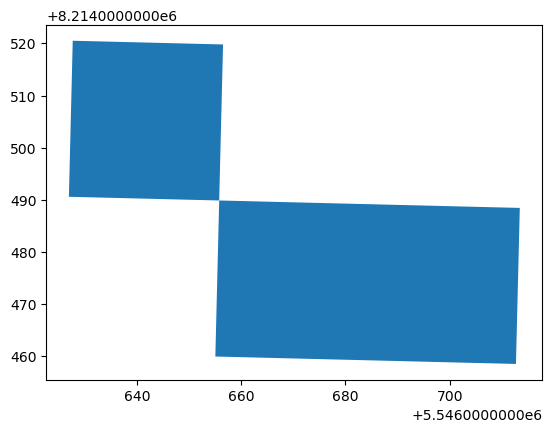

In [65]:
pols_ddf.loc[[0], :].plot()

<AxesSubplot:>

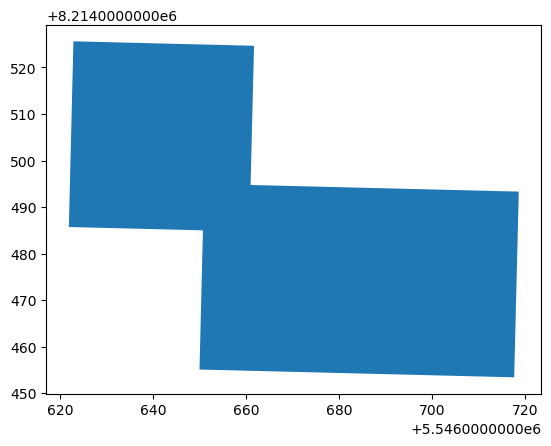

In [66]:
pols_ddf2.loc[[0], :].plot()

In [ ]:
pols_ddf = pols_ddf.spatial_shuffle()

In [ ]:
pols_ddf.spatial_partitions.explore()

## Exploring how it would be to merge August and September

In [ ]:
pols_aug = pols[pols['month'] == 8]
pols_sep = pols[pols['month'] == 9]

In [ ]:
pols_aug = pols_aug.reset_index(drop = True)
pols_sep = pols_sep.reset_index(drop = True)

In [ ]:
pols_aug['ID_aug'] = pols_aug.index
pols_sep['ID_sep'] = pols_sep.index + pols_aug['ID_aug'].max() + 1

In [ ]:
pols_aug.head()

In [ ]:
pols_aug.tail()

In [ ]:
pols_sep.head()

### With dask-geopandas

Converting to dask-geopandas

In [ ]:
pols_aug_ddf = dgpd.from_geopandas(
    pols_aug,
    npartitions=12
)
pols_sep_ddf = dgpd.from_geopandas(
    pols_sep,
    npartitions=12
)

In [ ]:
pols_aug_ddf.head()

In [ ]:
pols_sep_ddf.head()

In [ ]:
pols_aug_ddf = pols_aug_ddf.spatial_shuffle()
pols_sep_ddf = pols_sep_ddf.spatial_shuffle()

In [ ]:
pols_aug_ddf.spatial_partitions.explore()

In [ ]:
pols_sep_ddf.spatial_partitions.explore()

In [ ]:
joined = pols_sep_ddf.sjoin(pols_aug_ddf, predicate="touches")

In [ ]:
joined.npartitions

In [ ]:
pols_aug_ddf.npartitions

In [ ]:
pols_sep_ddf.npartitions

Using the spatial joins, we are already reducing the amount of checks between groups.

I would say that I would first take the buffer of geometries (to 5 m), then calculate the spatial partitions, then do the spatial join.

In [ ]:
%%time
joined = joined.compute()

Before this last step, previous steps had only taken a few seconds.

The question is how does this time compares to the id_components...

<font color=red> Another challenge is how to turn this into what I want. First, make sure that the resulting polygons make sense. Then, decide on the columns and index to keep. As well, all those elements that have index_right repeated, should be dissolved into a unique geometry.</font>

In [ ]:
joined

In [ ]:
joined['ID_aug'].sort_values().unique()

In [ ]:
joined['ID_sep'].sort_values().unique()

In [ ]:
joined = joined.reset_index(drop = True)

In [ ]:
joined

Constructing the sparse matrix. I think in principle it does not matter if the matrix directed or not.

In [ ]:
%%time
sparse_matrix = csr_matrix((np.ones(len(joined)), (joined['ID_aug'], joined['ID_sep'])), shape = (pols_sep['ID_sep'].max() + 1, pols_sep['ID_sep'].max() + 1))

Calculating connected components

In [ ]:
%%time
output = connected_components(sparse_matrix)

Now I believe is just a matter of concatenating the pols_aug and pols_sep and assign output[1] as the conn_ids column

In [ ]:
pols_aug_sep = gpd.GeoDataFrame( pd.concat([pols_aug, pols_sep], ignore_index = True), crs = pols_aug.crs)

In [ ]:
len(pols_aug_sep)

In [ ]:
len(output[1])

In [ ]:
pols_aug_sep['conn_ids'] = output[1]

In [ ]:
pols_aug_sep.head(20)

I want to check if there are indeed duplicates, and if they seem to belong to groups of polygons (visual chekc with ID and QGIS)

In [ ]:
duplicates = pols_aug_sep['conn_ids'].duplicated(keep = False)

In [ ]:
pols_aug_sep['dup'] = duplicates

In [ ]:
pols_aug_sep[pols_aug_sep['dup'] == True].head(20)

Awesome, seems to be working! Now let's check visually that it makes sense!

In [ ]:
pols_aug_sep[pols_aug_sep['conn_ids'] == 22]

<font color = green>It is correct!</font>

In [ ]:
pols_aug_sep[pols_aug_sep['conn_ids'] == 52]

<font color = green>It is correct!</font>

In [ ]:
pols_aug_sep[pols_aug_sep['conn_ids'] == 83]

<font color = green>It is correct!</font>

In [ ]:
pols_aug_sep[pols_aug_sep['dup'] == True].tail(20)

In [ ]:
pols_aug_sep[pols_aug_sep['conn_ids'] == 7991].head(40)

<font color = green>It is correct!</font>

## Summary of new method

 1. Get the two geodataframes, for the two consecutive months
 1. Reset their indices
 1. Create ID column with different names as per cell 11.
 1. Cast them into das-geopandas dataframes
 1. draw the spatial partitions for each one of them
 1. do the spatial join. Make sure order is consistent: first month first
 1. compute the spatial join
 1. reset and drop index
 1. Create sparse matrix as per cell 44
 1. Calculate the connected components
 1. Drop recently created ID columns from original month dataframes, and concatenate them. Make sure th order is consistent: first month first
 1. Free memory of the two month polygons
 1. Make sure length of this dataframe is the same as length of connected components (for sanity)
 1. Then, script shall proceed as it already is.
 
 
 
 - Test in local with year 2000 polygons, because if there is not much time improvement, then there is no point
 - If there is substantial time improvement, then update the dask-geopandas library in the Linux cluster (will I need to stop what is already running?)
 - Run files that are left with the new method

ok... so this takes a little less time.

The dask method does not merge the polygons, it just detects polygons that are connected.

So, out of this I am only interested in the ID_left and ID_right columns. This seems to be a way of indicating the connected compoents, I wonder if there is an easy way of turning it into ID -> conn_ids.

So, all of this would just be a way to get a substitute for id_components. In a subset, both take similar times. When doing the full data, would it be any faster?

We have learned that
 - The elements that are not to be joined are dropped from the dataframe
 - If we assign a unique ID to each polygon in the two months dataframes, then when we get the joined dataframe we are effectively getting a sparse matrix and it should be easy to return the connected components
 - This last function would work using a sparse matrix 
 
I have to install scipy.

## Checking time spent by my new method

In [ ]:
pols_time = gpd.read_file('../../data/temp/fixed/2000/MBfogo_c10_cerrado_polygons_2000_buff150.shp')

In [ ]:
pols_time_aug = pols_time[pols_time['month'] == 8]
pols_time_sep = pols_time[pols_time['month'] == 9]

In [ ]:
del pols_time

In [ ]:
%%time
pols_time_aug = dgpd.from_geopandas(
        pols_time_aug,
        npartitions = 12)
pols_time_sep = dgpd.from_geopandas(
        pols_time_sep,
        npartitions = 12)

In [ ]:
%%time
pols_time_aug = pols_time_aug.spatial_shuffle()
pols_time_sep = pols_time_sep.spatial_shuffle()

In [ ]:
pols_time_aug.spatial_partitions.explore()

In [ ]:
joined = pols_time_aug.sjoin(pols_time_sep, predicate="touches")

In [ ]:
%%time
joined.compute()

Compare the above with using ID_components on the same file... THIS PROBABLY TAKES A WHILE!

### With id_connectedComponents

In [ ]:
import sys
sys.path.append('../processing/')
from MBfogo_mergePolygons_consecutiveMonths import id_connectedComponents

In [ ]:
pols_time = gpd.read_file('../../data/temp/fixed/2000/MBfogo_c10_cerrado_polygons_2000_buff150.shp')

In [ ]:
pols_time_aug = pols_time[pols_time['month'] == 8]
pols_time_sep = pols_time[pols_time['month'] == 9]

In [ ]:
del pols_time

In [ ]:
pols_time_aug_sep = gpd.GeoDataFrame( pd.concat([pols_time_aug, pols_time_sep], ignore_index = True), crs = pols_time_aug.crs)

In [ ]:
pols_time_aug_sep.crs

In [ ]:
pols_time_aug_sep = pols_time_aug_sep.to_crs('epsg:5880')

In [ ]:
%%time
output = id_connectedComponents(pols_time_aug_sep)